In [1]:
# Generate Gaussian Process for total station data file

# Notebook used to compute the trajectories of prisms with Gaussian Process

In [1]:
import sys
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib
import random
import os
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import spatial
from IPython.display import HTML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel)

import importlib
import scripts.theodolite_function as tfu
import scripts.theodolite_utils as tfuu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.gp_prediction_utils as GPf
GPf = importlib.reload(GPf)
import GPy
from wbml.plot import tweak
from stheno import B, Measure, GP, EQ, Delta
import torch

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
# Switch values if necessary 1 11 2021
#Dist_prism_12 = 1.0398341231585624*1000
#Dist_prism_13 = 0.818424700118086*1000
#Dist_prism_23 = 0.8806156053859284*1000
#Dist_GPS_12 = 0.835637436093363*1000
#Dist_GPS_13 = 0.7812173648662254*1000
#Dist_GPS_23 = 0.5166745729506486*1000

# 26 11 2021
#Dist_prism_12 = 1.03688797895733
#Dist_prism_13 = 0.822536135483593
#Dist_prism_23 = 0.8783765747673403
#Dist_GPS_12 = 0.7828618536473139
#Dist_GPS_13 = 0.8394208131018045
#Dist_GPS_23 = 0.5176447366930409

# 31 01 2022
#Dist_prism_12 = 1.038854051807371
#Dist_prism_13 = 0.8202157646292075
#Dist_prism_23 = 0.879788333022114
#Dist_GPS_12 = 0.7830826912858335
#Dist_GPS_13 = 0.8418404054627937
#Dist_GPS_23 = 0.5172558618541933
     
# 03 02 2022
#Dist_prism_12 = 1.0403741344089559
#Dist_prism_13 = 0.8239475424257701
#Dist_prism_23 = 0.8766711748547112
#Dist_GPS_12 = 0.781661929058067
#Dist_GPS_13 = 0.8353981332464246
#Dist_GPS_23 = 0.5174987476948135

# 17 02 2022 / 24 02 2022
#Dist_prism_12 = 0.8882613537922258
#Dist_prism_13 = 0.8262903370535766
#Dist_prism_23 = 1.0377436460567973
#Dist_GPS_12 = 0.7809786915630756
#Dist_GPS_13 = 0.8378323585433202
#Dist_GPS_23 = 0.5191788936274444  

# 07 03 2022
#Dist_prism_12 = 0.8832836583456264
#Dist_prism_13 = 0.8247449387008166
#Dist_prism_23 = 1.039409793600046
#Dist_GPS_12 = 0.7781099344563802
#Dist_GPS_13 = 0.8431026980109139
#Dist_GPS_23 = 0.5157221841320069

# 12 03 2022
#Dist_prism_12 = 0.8860734460339026
#Dist_prism_13 = 0.8303896290142598
#Dist_prism_23 = 1.0393117663247973
#Dist_GPS_12 = 0.7829424296161074
#Dist_GPS_13 = 0.8415176433032493
#Dist_GPS_23 = 0.5161917038941966

# 14 03 2022 / 16 03 2022
#Dist_prism_12 = 0.8873171656784946
#Dist_prism_13 = 0.8272212117473343
#Dist_prism_23 = 1.0379270641796363
#Dist_GPS_12 = 0.7829081036179948
#Dist_GPS_13 = 0.8424633975958637
#Dist_GPS_23 = 0.5165807364575292

# 31 03 2022
Dist_prism_12 = 0.8864675130714769
Dist_prism_13 = 0.8240907534046003
Dist_prism_23 = 1.0386580905077105
Dist_GPS_12 = 0.7840545151932103
Dist_GPS_13 = 0.8371156718750876
Dist_GPS_23 = 0.5167633057807889

# 27 04 2022
#Dist_prism_12 = 0.8856608085851714
#Dist_prism_13 = 0.8264452483880412
#Dist_prism_23 = 1.0384219210289538
#Dist_GPS_12 = 0.7809547832390561
#Dist_GPS_13 = 0.8259590286006459
#Dist_GPS_23 = 0.5191274645630007  

# 27 04 2022 soir
#Dist_prism_12 = 0.8868846942534616
#Dist_prism_13 = 0.829169129877633
#Dist_prism_23 = 1.0387571594276301
#Dist_GPS_12 = 0.7837749633840095
#Dist_GPS_13 = 0.8323125081688734
#Dist_GPS_23 = 0.5187055120945835

# 05 05 2022
#Dist_prism_12 = 0.3819811991689936
#Dist_prism_13 = 0.4426382054042266
#Dist_prism_23 = 0.2564685508415531

# 13 05 2022
#Dist_prism_12 = 0.8113569618671205
#Dist_prism_13 = 0.8695313906832193
#Dist_prism_23 = 1.0383292631343506
#Dist_GPS_12 = 0.7800801192552722
#Dist_GPS_13 = 0.8396027021467387
#Dist_GPS_23 = 0.5157656903777014

Number sub-trajectories: 10


<IPython.core.display.Javascript object>


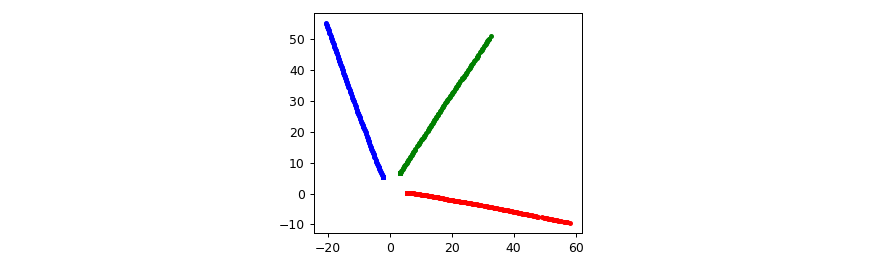

In [15]:
# Sort the data with the good intervals of time to process them

%matplotlib notebook
tfuu = importlib.reload(tfuu)
#path = "./data/total_station/20220314/"
path = "./data/raw_data/20220427_soir/"

time_trimble_1, trimble_1 = tfuu.read_point_data_csv_file(path+"trimble1.csv")
time_trimble_2, trimble_2 = tfuu.read_point_data_csv_file(path+"trimble2.csv")
time_trimble_3, trimble_3 = tfuu.read_point_data_csv_file(path+"trimble3.csv")

# Work on the data with 3 prisms and 3 theodolites
tfu = importlib.reload(tfu)
# Slipt the data into different interval according to the timestamps of the measurements
limit_time_interval = 3    #3 seconds max
list_interval, list_time = tfu.split_time_interval_all_data(time_trimble_1, time_trimble_2, time_trimble_3, limit_time_interval)
# Keep only the intervals where the three theodlites have done some measurements at the same time
limit_search = 2
#print(list_interval[2])
list_trajectories_split = tfu.merge_interval(list_interval, list_time, time_trimble_1, time_trimble_2, time_trimble_3, limit_search)
print("Number sub-trajectories:",len(list_trajectories_split))
# Plot subtrajectory for debug
tfu.plot_subtrajectory_result(0, list_trajectories_split, trimble_1, trimble_2, trimble_3)

In [16]:
# Show first sub-trajectory

po=list_trajectories_split[0]
print(po)
print(len(trimble_1[1,po[0,0]:po[1,0]]),len(trimble_2[1,po[0,1]:po[1,1]]),len(trimble_3[1,po[0,2]:po[1,2]]))
print(min(time_trimble_1[po[0,0]],time_trimble_2[po[0,1]],time_trimble_3[po[0,2]]))
#print(max(time_trimble_1[po[1,0]],time_trimble_2[po[1,1]],time_trimble_3[po[1,2]]))

[[  1   0   1]
 [272 270 265]]
271 270 264
1651113199.7242978


In [17]:
import scripts.theodolite_utils as tfuu
tfuu = importlib.reload(tfuu)
import warnings
import time
from tqdm import tqdm
warnings.filterwarnings('ignore')
tfu = importlib.reload(tfu)
GPf = importlib.reload(GPf)
#path_data = "./data/total_station/20220513_morning_without_lidar_2/"
#path = "./data/prediction/"
path_data = "./data/raw_data/20220427_soir/"
path = "./data/raw_data/20220427_soir/"
B.epsilon = 1e-8
save = True
verbose=False
noise_GP = 0
variance_GP = 1
lengthscale_GP = 1

limit_points_windows = [18,18]
Mode_window = "ground-truth"

mode_arr = ["GP"]
size_interval_arr = [10]
number_restart_arr = [20]
trajectoire_arr = ["10-20"] #interval-restart
file_open = [path_data+"trimble"]
file_save = [path+"TS/1611-"+mode_arr[0]+"-"+trajectoire_arr[0]+"_"]
time_origin = 1651113199     ######### Important, need to change it, timestamp given by the function above

for m,n,p,r,s,nr in zip(mode_arr, size_interval_arr, trajectoire_arr, file_open, file_save, number_restart_arr):
    
    time_trimble_1, trimble_1 = tfuu.read_point_data_csv_file(r+"1"+".csv")
    time_trimble_2, trimble_2 = tfuu.read_point_data_csv_file(r+"2"+".csv")
    time_trimble_3, trimble_3 = tfuu.read_point_data_csv_file(r+"3"+".csv")
    
    time_trimble_1 = time_trimble_1 - np.ones_like(time_trimble_1)*time_origin
    time_trimble_2 = time_trimble_2 - np.ones_like(time_trimble_2)*time_origin
    time_trimble_3 = time_trimble_3 - np.ones_like(time_trimble_3)*time_origin
    
    limit_time_interval = 3
    list_interval, list_time = tfu.split_time_interval_all_data(time_trimble_1, time_trimble_2, time_trimble_3, limit_time_interval)
    limit_search = 1
    list_trajectories_split = tfu.merge_interval(list_interval, list_time, time_trimble_1, time_trimble_2, time_trimble_3, limit_search)
    
    start_time = time.time()
    Mode = m
    trajectoire = p
    size_interval = n
    
    Number_points_window = []
    Prediction_1_MGPO = []
    Prediction_2_MGPO = []
    Prediction_3_MGPO = []
    Prediction_1_GP = []
    Prediction_2_GP = []
    Prediction_3_GP = []
    T_prediction = []
    compteur = 0
    
    for i in tqdm(list_trajectories_split):
        
        index_1 = np.array([i[0,0],i[1,0]])
        index_2 = np.array([i[0,1],i[1,1]])
        index_3 = np.array([i[0,2],i[1,2]])

        begin = np.max([time_trimble_1[index_1[0]], time_trimble_2[index_2[0]], time_trimble_3[index_3[0]]])
        end = np.min([time_trimble_1[index_1[1]], time_trimble_2[index_2[1]], time_trimble_3[index_3[1]]])
        rate = 5  #Hz
        T_prediction_init = torch.from_numpy(np.arange(begin, end, 1/rate))

        if(abs(end-begin)>n):

            if(Mode == "MGPO" or Mode == "All"):
                T_MGPO, S_MGPO = GPf.data_training_MGPO(time_trimble_1, time_trimble_2, time_trimble_2, trimble_1, 
                                                                     trimble_2, trimble_3, index_1, index_2, index_3)
                print("Training")
                m = GPf.training_MGPO(nr, verbose, T_MGPO, S_MGPO)
                print("Prediction")
                for i in T_prediction_init.numpy():
                    T_prediction.append(i+time_origin)
                    P1_MGPO, P2_MGPO, P3_MGPO = GPf.unit_prediction_MGPO(i, m)
                    Prediction_1_MGPO.append(P1_MGPO)
                    Prediction_2_MGPO.append(P2_MGPO)
                    Prediction_3_MGPO.append(P3_MGPO)

            if(Mode == "GP" or Mode == "All"):
                T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = GPf.data_training_GP(time_trimble_1, time_trimble_2, time_trimble_3, trimble_1, 
                                                                     trimble_2, trimble_3, index_1, index_2, index_3)
                print("Training")
                mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3 = GPf.training_GP(nr, verbose, T1, X1, Y1,
                                                                          Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3)
                print("Prediction")
                for i in T_prediction_init.numpy():
                    T_prediction.append(i+time_origin)
                    P1_GP, P2_GP, P3_GP = GPf.unit_prediction_GP(i, mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3)
                    Prediction_1_GP.append(P1_GP)
                    Prediction_2_GP.append(P2_GP)
                    Prediction_3_GP.append(P3_GP)

    stop_time = time.time()
    print(stop_time - start_time)
    
print("Finished !")

  0%|          | 0/8 [00:00<?, ?it/s]

Training
Prediction


 12%|█▎        | 1/8 [01:25<09:57, 85.36s/it]

Training
Prediction


 38%|███▊      | 3/8 [01:44<02:25, 29.04s/it]

Training
Prediction


 62%|██████▎   | 5/8 [01:59<00:54, 18.19s/it]

Training


 88%|████████▊ | 7/8 [02:12<00:13, 13.26s/it]

Prediction
Training
Prediction


100%|██████████| 8/8 [04:40<00:00, 35.03s/it]

280.2377178668976
Finished !


In [18]:
# Save file of GP

save = True
#path = "./data/prediction/"
path = "./data/raw_data/"
if(Mode == "MGPO" or Mode == "All"):
    trajectoire = "MGPO-10-20"
    if save:
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1_MGPO, path+trajectoire+ "_1.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2_MGPO, path+trajectoire+ "_2.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3_MGPO, path+trajectoire+ "3.csv")
if(Mode == "GP" or Mode == "All"):
    trajectoire = "GP-10-20"
    if save:
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1_GP, path+trajectoire+ "_1.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2_GP, path+trajectoire+ "_2.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3_GP, path+trajectoire+ "_3.csv")

Conversion done !
Conversion done !
Conversion done !


Mean e:  722.3929016214519 22170.59853904845 20977.69055486716
Variance e:  553.1497445383739 10446.66232474875 10679.775771385213


<IPython.core.display.Javascript object>


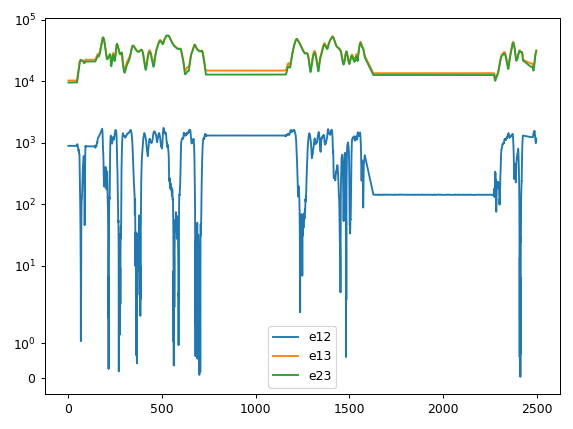

In [7]:
# Show inter-prism error obtained

%matplotlib notebook
GPf = importlib.reload(GPf)
error_euclidian_GP, T_prediction = GPf.error_calculation_eucli(Prediction_1_GP, Prediction_2_GP, Prediction_3_GP, Dist_prism_12, Dist_prism_13, Dist_prism_23)
error_e_GP = np.array(error_euclidian_GP)
print("Mean e: ", np.mean(error_e_GP[:,0]),np.mean(error_e_GP[:,1]),np.mean(error_e_GP[:,2]))
print("Variance e: ", np.std(error_e_GP[:,0]),np.std(error_e_GP[:,1]),np.std(error_e_GP[:,2]))
plt.figure(0)
plt.plot(T_prediction, error_e_GP[:,0], label="e12")
plt.plot(T_prediction, error_e_GP[:,1], label="e13")
plt.plot(T_prediction, error_e_GP[:,2], label="e23")
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
#ax.set_ylim([0, 1])
plt.show()